## SUITE P4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## COMPARAISON ET SYNTHESE DES RESULTATS POUR LES MODELES UTILISES

Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. Ici nous sommes en Google Colab, donc l'accès au GPU est illimité.

In [ ]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10796414979598788215, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14512029696
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15278138733371244321
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
#Vérification de la RAM
!cat /proc/meminfo

MemTotal:       26696424 kB
MemFree:        20185044 kB
MemAvailable:   25252396 kB
Buffers:          193364 kB
Cached:          4835648 kB
SwapCached:            0 kB
Active:          2120964 kB
Inactive:        3845920 kB
Active(anon):     722772 kB
Inactive(anon):    10764 kB
Active(file):    1398192 kB
Inactive(file):  3835156 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1340 kB
Writeback:             0 kB
AnonPages:        937788 kB
Mapped:           650696 kB
Shmem:             11496 kB
KReclaimable:     251492 kB
Slab:             330200 kB
SReclaimable:     251492 kB
SUnreclaim:        78708 kB
KernelStack:        6600 kB
PageTables:         9816 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13348212 kB
Committed_AS:    4681668 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       52904 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
pip install catboost

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [ ]:
%cd /content/LightGBM

/content/LightGBM


In [ ]:
!mkdir build

mkdir: cannot create directory ‘build’: File exists


In [ ]:
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)

-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[ 79%] Built target lightgbm
[100%] Built target _lightgbm


In [ ]:
!sudo apt-get -y install python-pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
%cd /content/LightGBM/python-package

/content/LightGBM/python-package


In [ ]:
!sudo python setup.py install — precompile

invalid command name '—'


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
import seaborn as sb
import time, pickle
import os

from zipfile import ZipFile

#Prétraitement, suréchantillonnage, sélection de modèle, évaluation de modèle
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate,KFold


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [ ]:
# Télecharger le fichier de jeu de données équilibrés
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
z = ZipFile("/content/gdrive/My Drive/Colab Notebooks/input/Var_imp.zip")
Var_imp = pd.read_csv(z.open('Var_imp.csv'))

Var_imp.shape

(662860, 21)

In [ ]:
Var_imp

,Unnamed: 0,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,PREV_BUR_MEAN_DAYS_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE_Secondary / secondary special,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,REGION_RATING_CLIENT_W_CITY,NAME_INCOME_TYPE_Working,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,PREV_APPL_MEAN_DAYS_DECISION,CODE_GENDER_M,DAYS_ID_PUBLISH,EMERGENCYSTATE_MODE_No,ELEVATORS_MEDI,FLOORSMAX_AVG,PREV_BUR_MEAN_DAYS_ENDDATE_FACT
0,0,1.0,0.307542,0.155054,0.073300,0.700890,0.881337,0.964437,1.0,0.987737,0.750000,1.0,0.739968,1.0,0.793151,1.0,0.705433,1.000000,0.00,0.083300,0.916731
1,1,0.0,0.727773,0.595159,0.313736,0.520619,0.473087,0.933676,0.0,0.980193,0.500000,0.0,0.810135,1.0,0.553767,0.0,0.959566,1.000000,0.08,0.291700,0.868999
2,2,0.0,0.650190,0.814130,0.519046,0.703285,0.345593,0.987439,1.0,0.986970,0.750000,1.0,0.813116,0.0,0.721575,1.0,0.648326,0.000000,0.00,0.166700,0.936429
3,3,0.0,0.760751,0.595159,0.519046,0.639802,0.347884,0.830337,1.0,0.988228,0.750000,1.0,0.858519,1.0,0.907382,0.0,0.661387,0.000000,0.00,0.166700,0.889405
4,4,0.0,0.377472,0.595159,0.519046,0.606776,0.296071,0.830393,1.0,0.980980,0.750000,1.0,0.746388,0.0,0.581906,1.0,0.519522,0.000000,0.00,0.166700,0.906524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662855,662855,1.0,0.232275,0.248908,0.519046,0.944229,0.414898,0.944263,1.0,0.997241,0.750000,1.0,0.823446,1.0,0.779538,1.0,0.764924,0.000000,0.00,0.166700,0.892926
662856,662856,1.0,0.644083,0.360471,0.519046,0.463380,0.617653,0.984173,1.0,0.990022,0.768832,1.0,0.893660,1.0,0.919978,0.0,0.433608,1.000000,0.00,0.166700,0.697703
662857,662857,1.0,0.393880,0.059486,0.519046,0.925785,0.622990,0.961884,1.0,0.999121,1.000000,1.0,0.940217,0.0,0.936183,0.0,0.705244,0.000000,0.00,0.166700,0.997252
662858,662858,1.0,0.586597,0.318129,0.085116,0.602972,0.678005,0.736259,1.0,0.982637,0.750000,1.0,0.944038,1.0,0.618627,1.0,0.851677,1.000000,0.00,0.011969,0.893496


In [ ]:
Var_imp = Var_imp.drop('Unnamed: 0', axis=1)

In [ ]:
Var_imp.dtypes.value_counts()

float64    20
dtype: int64

In [ ]:
Var_imp

,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,PREV_BUR_MEAN_DAYS_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,NAME_EDUCATION_TYPE_Secondary / secondary special,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,REGION_RATING_CLIENT_W_CITY,NAME_INCOME_TYPE_Working,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,PREV_APPL_MEAN_DAYS_DECISION,CODE_GENDER_M,DAYS_ID_PUBLISH,EMERGENCYSTATE_MODE_No,ELEVATORS_MEDI,FLOORSMAX_AVG,PREV_BUR_MEAN_DAYS_ENDDATE_FACT
0,1.0,0.307542,0.155054,0.073300,0.700890,0.881337,0.964437,1.0,0.987737,0.750000,1.0,0.739968,1.0,0.793151,1.0,0.705433,1.000000,0.00,0.083300,0.916731
1,0.0,0.727773,0.595159,0.313736,0.520619,0.473087,0.933676,0.0,0.980193,0.500000,0.0,0.810135,1.0,0.553767,0.0,0.959566,1.000000,0.08,0.291700,0.868999
2,0.0,0.650190,0.814130,0.519046,0.703285,0.345593,0.987439,1.0,0.986970,0.750000,1.0,0.813116,0.0,0.721575,1.0,0.648326,0.000000,0.00,0.166700,0.936429
3,0.0,0.760751,0.595159,0.519046,0.639802,0.347884,0.830337,1.0,0.988228,0.750000,1.0,0.858519,1.0,0.907382,0.0,0.661387,0.000000,0.00,0.166700,0.889405
4,0.0,0.377472,0.595159,0.519046,0.606776,0.296071,0.830393,1.0,0.980980,0.750000,1.0,0.746388,0.0,0.581906,1.0,0.519522,0.000000,0.00,0.166700,0.906524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662855,1.0,0.232275,0.248908,0.519046,0.944229,0.414898,0.944263,1.0,0.997241,0.750000,1.0,0.823446,1.0,0.779538,1.0,0.764924,0.000000,0.00,0.166700,0.892926
662856,1.0,0.644083,0.360471,0.519046,0.463380,0.617653,0.984173,1.0,0.990022,0.768832,1.0,0.893660,1.0,0.919978,0.0,0.433608,1.000000,0.00,0.166700,0.697703
662857,1.0,0.393880,0.059486,0.519046,0.925785,0.622990,0.961884,1.0,0.999121,1.000000,1.0,0.940217,0.0,0.936183,0.0,0.705244,0.000000,0.00,0.166700,0.997252
662858,1.0,0.586597,0.318129,0.085116,0.602972,0.678005,0.736259,1.0,0.982637,0.750000,1.0,0.944038,1.0,0.618627,1.0,0.851677,1.000000,0.00,0.011969,0.893496


### Extraire les données pour entrainer notre jeux de données

In [ ]:
X_imp = Var_imp.drop('TARGET', axis=1)
y_imp = Var_imp['TARGET']

### Préparation du jeu de données

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.3, random_state=42)

### Définir une fonction

In [ ]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['Vrai Neg', 'Faux Pos', 'Faux Neg', 'Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Taux de faux positif')
    plt.ylabel('Taux de vrai positif')
    plt.legend()
    

### BASELINE

#### Régression logistique

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer. La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performance possibles, la modélisation par régression logistique permettra d'obtenir une première baseline optimisé.

In [ ]:
from sklearn.linear_model import LogisticRegression

Comme pour le modèle linéaire, il faudrait construire les commandes d’aide à
l’interprétation des résultats.
Pénalisation et optimisation du paramètre par validation croisée.
GridSearchCV sera utilisé.

In [ ]:
from sklearn.model_selection import GridSearchCV
# grille de valeur
param=[{"C":[0.01,0.05,0.1,0.15,1,10]}]
logist= GridSearchCV(LogisticRegression(penalty="l2"),param,cv=5,n_jobs=-1)
pre_logist=logist.fit(X_train, y_train)

In [ ]:
pre_logist.best_params_["C"]

0.1

**Estimation du modèle "optimal" de régression logique.**

In [ ]:
%%time
model1 =  LogisticRegression(C=0.1,penalty="l2")
model1.fit(X_train,y_train)
roc_auc = roc_auc_score(y_test, model1.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, model1.predict(X_test)))

AUC : 0.7534
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69     99354
         1.0       0.69      0.70      0.69     99504

    accuracy                           0.69    198858
   macro avg       0.69      0.69      0.69    198858
weighted avg       0.69      0.69      0.69    198858

CPU times: user 14.1 s, sys: 16.2 s, total: 30.3 s
Wall time: 7.95 s


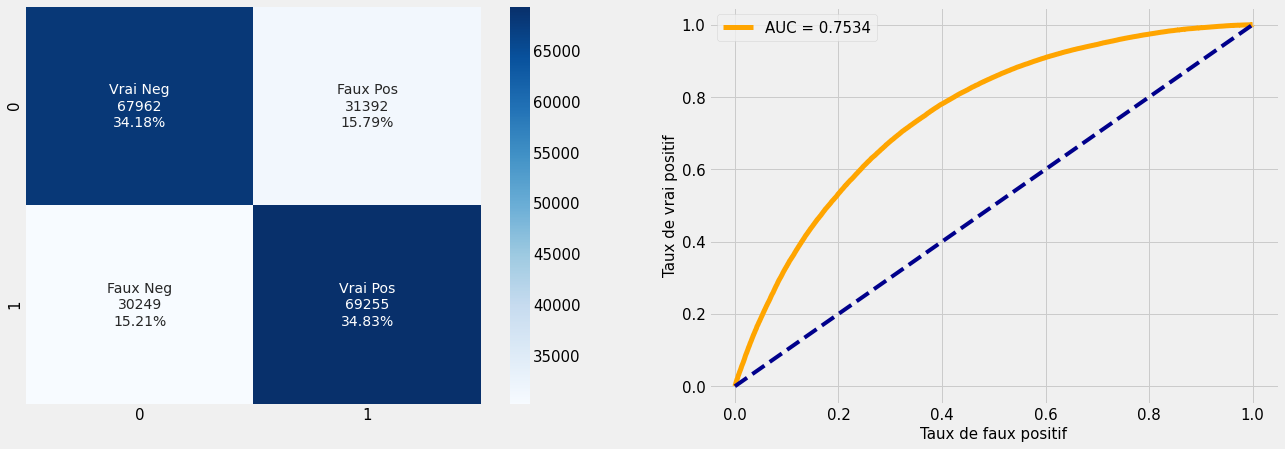

In [ ]:
cf_matrix_roc_auc(model1, y_test, model1.predict(X_test), model1.predict_proba(X_test)[:,1], feature_importances=None)

On note un AUC de 75.34% et un taux de faux positif de 15.79% que nous prendrons comme première baseline.

#### Arbre de décision

Les arbres binaires de décision (CART : classification and regression trees)
s’appliquent à tous types de variables. Les options de l’algorithme sont décrites dans la documentation. La complexité du modèle est gérée par deux paramètres : max_depth, qui détermine le nombre max de feuilles dans l’arbre,
et le nombre minimales min_samples_split d’observations requises pour
rechercher une dichotomie(division d'un organe végétal se séparant en deux).


Estimation de l’arbre complet

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param=[{"max_depth":list(range(1,10))}]
pre_arbre=GridSearchCV(DecisionTreeClassifier(), param,cv=5,n_jobs=-1)
pre_arbre_opt=pre_arbre.fit(X_train,y_train)

In [ ]:
pre_arbre_opt.best_params_

{'max_depth': 9}

**Estimation du modèle "optimal" de l'arbre.**

In [ ]:
%%time
model2 =  DecisionTreeClassifier(max_depth=9)
model2.fit(X_train,y_train)
roc_auc = roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
predictors=list(X_train)
print('Précision du GBM sur l’ensemble de test: {:.3f}'.format(model2.score(X_test, y_test)))
pred=model2.predict(X_test)
print(classification_report(y_test, pred))

AUC : 0.8437
Précision du GBM sur l’ensemble de test: 0.757
              precision    recall  f1-score   support

         0.0       0.74      0.79      0.76     99354
         1.0       0.77      0.73      0.75     99504

    accuracy                           0.76    198858
   macro avg       0.76      0.76      0.76    198858
weighted avg       0.76      0.76      0.76    198858

CPU times: user 6.54 s, sys: 11 ms, total: 6.55 s
Wall time: 6.52 s


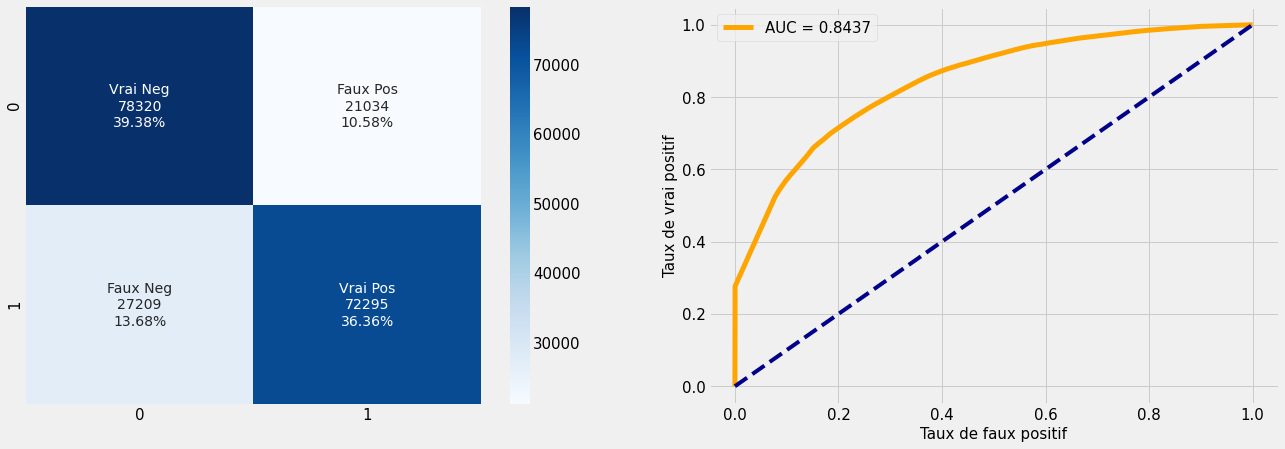

In [ ]:
cf_matrix_roc_auc(model2, y_test, model2.predict(X_test), model2.predict_proba(X_test)[:,1], feature_importances=None)

On note un AUC de 84.37% et un taux de faux positif de 10.58% que nous prendrons comme baseline de travail du fait que l'arbre de décision est plus performant que la régression logistique.

### Gradient Boosting

**Modèles prédictifs**

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]

In [ ]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [ ]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

In [ ]:
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []
fp=[]

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)
    cf =  cost_false(model,y_test,X_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)
    fp.append(cf[0])
    

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_,fp]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time','fp']
base_models.sort_values('AUC', ascending=False, inplace=True)

False Pos: 4.32%
False Neg: 7.67%
False Pos: 4.17%
False Neg: 7.93%
False Pos: 7.56%
False Neg: 8.82%


In [ ]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time,fp
0,CatBoostClassifier,0.947878,0.88006,0.907442,0.846659,0.875998,9.61533,0.0432117
1,LGBMClassifier,0.947481,0.878999,0.909931,0.841474,0.874364,6.81352,0.041678
2,XGBClassifier,0.917335,0.8362,0.844973,0.823786,0.834245,1.90511,0.0756268


LGBMClassifier a le temps de traitement le plus long néanmoins sa précision est la meilleurs et son taux de faux positif(fp) est le plus bas c'est pour celà qu'il reste le modèle le plus performant. Mon choix se portera sur LGBMClassifier.

## INTERPRETABILITE DU MODELE

### Réglage d’hyperparamètres

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [ ]:
!git clone https://github.com/hyperopt/hyperopt-sklearn.git

fatal: destination path 'hyperopt-sklearn' already exists and is not an empty directory.


In [ ]:
!cd hyperopt

/bin/bash: line 0: cd: hyperopt: No such file or directory


In [ ]:
!pip install -e .

Obtaining file:///content/LightGBM/python-package
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.2.1.99
    Can't uninstall 'lightgbm'. No files were found to uninstall.
  Running setup.py develop for lightgbm


In [ ]:
!pip install hpsklearn

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

Espace des paramètres

In [ ]:
space = {
    "n_estimators": hp.choice("n_estimators", [100,200,600]),
    'learning_rate': hp.choice('learning_rate',[0.1,0.01,0.001]),
    "max_depth": hp.choice("max_depth", [1,4, 7])
    }

In [ ]:
def objective(params, eval_metric='roc_auc'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        #'criterion': params['criterion'],
        #'boosting_type': params['boosting_type'],
        'learning_rate': params['learning_rate'],
        'device':'gpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

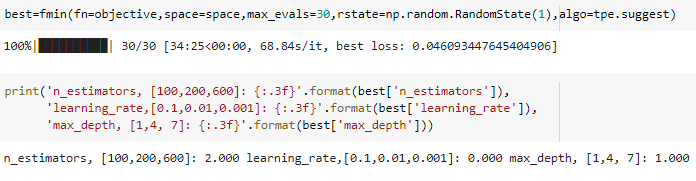

In [ ]:
%%time
lgbm = LGBMClassifier( 
                      n_estimators= 600,
                      learning_rate=0.1,
                      criterion='entropy',
                      boosting_type='gbdt', 
                      objective='binary',
                      max_depth = 4,
                      device='gpu'
                      )

CPU times: user 26 µs, sys: 11 µs, total: 37 µs
Wall time: 40.8 µs


In [ ]:
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: criterion


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               criterion='entropy', device='gpu', importance_type='split',
               learning_rate=0.1, max_depth=4, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.953819


In [ ]:
%%time
predictors=list(X_train)
print('Précision du GBM sur l’ensemble de test: {:.3f}'.format(lgbm.score(X_test, y_test)))
pred=lgbm.predict(X_test)
print(classification_report(y_test, pred))

Précision du GBM sur l’ensemble de test: 0.889
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89     99354
         1.0       0.91      0.86      0.89     99504

    accuracy                           0.89    198858
   macro avg       0.89      0.89      0.89    198858
weighted avg       0.89      0.89      0.89    198858

CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 10.9 s


### Modèle LGBMClassifier Optimisé

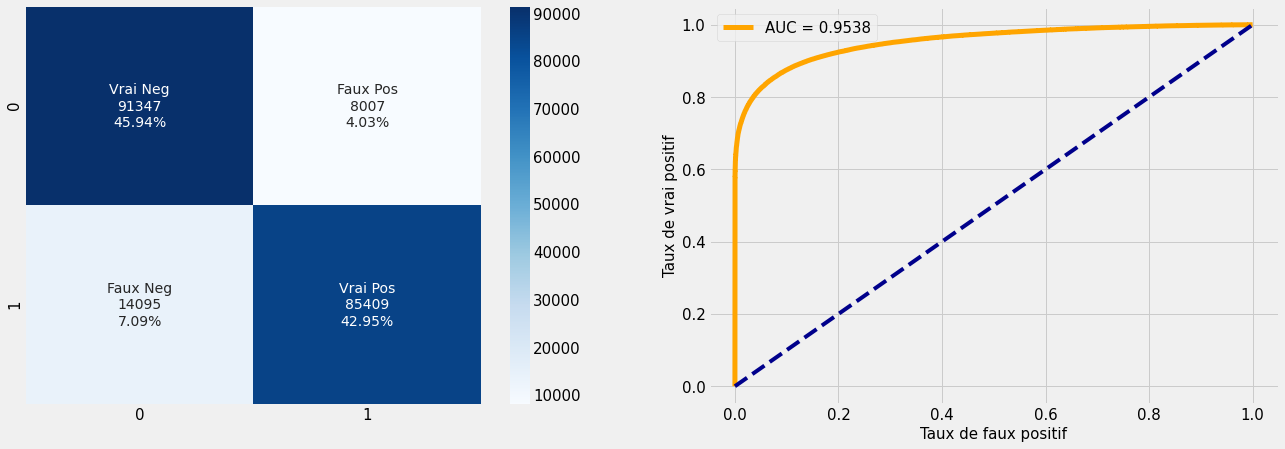

In [ ]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:,1], feature_importances=None)

On note que notre modèle LGBMClassifier Optimisé a un AUC de 95.38% et un taux de faux positif de 4.03% légérement meilleur que le modèle de base LGBMClassifier qui comptabilisait un AUC de 94.75% et un taux de faux positif de 4.17%.

### Importance des variables

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

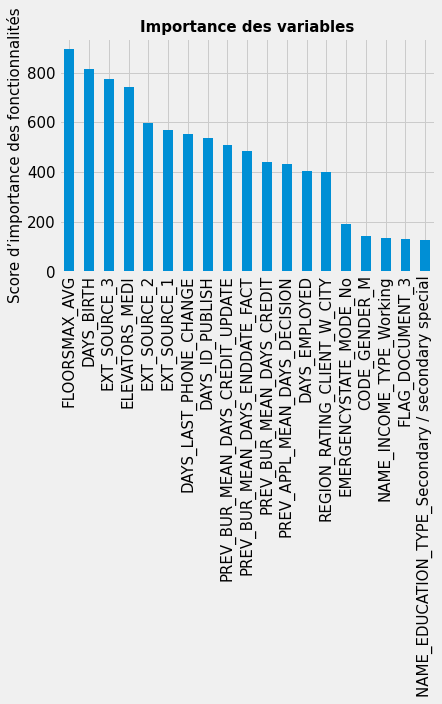

In [ ]:
feat_imp = pd.Series(lgbm.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance des variables')
plt.ylabel('Score d’importance des fonctionnalités')
plt.xticks(rotation=90)

On constate que la distribution des 19 variables les plus importantes classé par score d'importance des fonctionnalités de manière décroissante, on remarque que la variable FLOORSMAX_AVG apparaît en haut de se classement. 

### La fonction coût 

La fonction coût sera déterminée par l'analyse des erreurs de prédiction
FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.

- Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive.

- Perte réelle si le crédit client accepté se transforme en défaut de paiement.

Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.

L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

$$\begin{aligned}{\text{Precision}}={\frac {tp}{tp+fp}}\\{\text{Recall}}={\frac {tp}{tp+fn}}\,\end{aligned}$$
Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:$$\begin{aligned}{\text{Fscore}}={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}$$

Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall :$$\begin{aligned}{\text{Fscore}}={\frac {precision.recall}{Beta^2.precision + recall}}\,=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}$$

_Explication sur la F-measure Wikipedia_

L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β). Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.
$$\begin{aligned}{\text{Beta}}={\frac {coef Recall}{coef Precision}}\end{aligned}$$

On peut se fixer l'hypothèse d'un Beta = 3. Vérifions-le avec une étape de tests fonctionnels.

In [ ]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

## CONCLUSION

Après avoir rééquilibré mon jeu de données, j'ai effectué une corrélation pour retenir les 29 variables les plus corrélés avec la TARGET, ensuite j'ai utiliser ces 30 variables dans une carte thermique des corrélation, qui m'a permis de réduire mon jeu de données à 25 variables, j'ai donc par la suite entrainer mon jeu de données sur ces 25 variables. A ce stade j'ai pu réaliser une baseline optimisée faite sur deux algorithmes simple, j'ai retenue l'arbre de décision comme baseline de travail dont l'AUC était estimé ≈ 84.37% et un taux de faux positif de 10.58%. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. J'ai donc pu démontrer les performances de ces algorithmes. LGBMClassifier a le temps de traitement le plus long néanmoins sa précision est la meilleurs et son taux de faux positif(fp) est le plus bas c'est pour celà qu'il reste le modèle le plus performant. Mon choix c'est porté sur LGBMClassifier pour l'optimisation des Hyperparamètres (Hyperopt).

On note que notre modèle LGBMClassifier Optimisé a un AUC de 95.38% et un taux de faux positif de 4.03% légérement meilleur que le modèle de base LGBMClassifier qui comptabilisait un AUC de 94.75% et un taux de faux positif de 4.17%.

Mon choix de modèle c'est porté sur le LGBMClassifier Optimisé.


La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à des organisme de crédits. Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro. 

